# Tweaking and Exporting RandomForestRegressor

In [1]:
import pandas as pd

df = pd.read_csv("../src/taxipred/data/taxi_trip_pricing_cleaned.csv", index_col=0)

df.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,Clear,3.48,0.51,0.15,116.81,36.4698
4,25.83,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180
5,8.64,Afternoon,Weekend,2.0,Medium,Clear,2.55,1.71,0.48,89.33,60.2028


In [2]:
df = pd.get_dummies(df, drop_first=True)

df.head()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Day_of_Week_Weekend,Traffic_Conditions_Low,Traffic_Conditions_Medium,Weather_Rain,Weather_Snow
0,19.35,3.0,3.56,0.80,0.32,53.82,36.2624,False,True,False,False,True,False,False,False
2,36.87,1.0,2.70,1.21,0.15,37.27,52.9032,True,False,False,True,False,False,False,False
3,30.33,4.0,3.48,0.51,0.15,116.81,36.4698,True,False,False,False,True,False,False,False
4,25.83,3.0,2.93,0.63,0.32,22.64,15.6180,True,False,False,False,False,False,False,False
5,8.64,2.0,2.55,1.71,0.48,89.33,60.2028,False,False,False,True,False,True,False,False


In [3]:
df.shape

(925, 15)

## train|val|test split

In [4]:
X, y = df.drop(columns="Trip_Price"), df["Trip_Price"]

X.shape, y.shape

((925, 14), (925,))

In [5]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(X,y,test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_full,y_train_full,test_size=0.11, random_state=42)

X_train_full.shape, X_train.shape, X_val.shape, X_test.shape

((832, 14), (740, 14), (92, 14), (93, 14))

## test different hyperparameters
- n_estimators: 100 -> 500 -> 1000 (higher = better but slower)
- max_depth: None -> 10 -> 20 (None = can cause overfitting)
- min_samples_split: 2 -> 5 -> 10 (higher values = can reduce overfitting)
- min_samples_leaf: 1 -> 2 -> 4 (higher = more even trees, reduce noise)

In [7]:
from model_testing import randomforest_hyperparameters

score = randomforest_hyperparameters(X_train, X_val, y_train, y_val)
score

,n_estimators,max_depth,min_samples_split,min_samples_leaf,mae,rmse,r2_score
0,100,NaN,2,2,4.074353,5.679763,0.943011
1,100,20.0,2,2,4.074353,5.679763,0.943011
2,100,10.0,2,2,4.072607,5.687713,0.942852
3,100,NaN,5,2,4.101483,5.689402,0.942818
4,100,20.0,5,2,4.101483,5.689402,0.942818
...,...,...,...,...,...,...,...
76,1000,20.0,10,4,4.498696,6.184378,0.932435
77,1000,NaN,10,4,4.498696,6.184378,0.932435
78,500,NaN,10,4,4.510023,6.199698,0.932100
79,500,20.0,10,4,4.510023,6.199698,0.932100


### default settings is better, except for min_samples_leaf, 2 is better than 1, for random_state = 42

## train model with best hyperparameters and check feature importance

In [12]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(min_samples_leaf=2, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_pred[0]

np.float64(64.85559767380956)

In [13]:
y_val.iloc[0]

np.float64(65.195)

In [18]:
feature_importance = pd.DataFrame([X.columns, model.feature_importances_])
feature_importance = feature_importance.T
feature_importance.columns = ["Feature", "Importance"]
feature_importance = feature_importance.sort_values(by= "Importance", ascending=False).reset_index(drop=True)
feature_importance

,Feature,Importance
0,Trip_Distance_km,0.523468
1,Per_Km_Rate,0.208875
2,Trip_Duration_Minutes,0.15357
3,Per_Minute_Rate,0.088277
4,Base_Fare,0.010959
5,Passenger_Count,0.004659
6,Traffic_Conditions_Low,0.001934
7,Day_of_Week_Weekend,0.001791
8,Traffic_Conditions_Medium,0.001482
9,Time_of_Day_Morning,0.001477


In [30]:
percentage = feature_importance.iloc[:7]["Importance"].sum()
percentage

np.float64(0.9917429920836042)

### distance is the most important one, duration a little less important, base_fare and passenger also has a little bit of importance
- toghether, these 7 features is 99% of the importance, could drop the non-numeric columns?

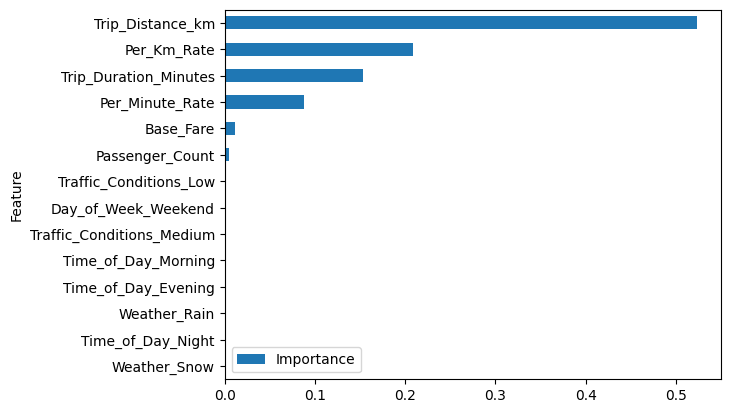

In [17]:
ax = feature_importance.plot(x="Feature", y="Importance", kind="barh")
ax.invert_yaxis()

## test model without the categorical features

In [26]:
df_numerics = pd.read_csv("../src/taxipred/data/taxi_trip_pricing_cleaned.csv", index_col=0).drop(columns=["Time_of_Day", "Day_of_Week", "Traffic_Conditions", "Weather"])

df_numerics.head()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,3.0,3.56,0.80,0.32,53.82,36.2624
2,36.87,1.0,2.70,1.21,0.15,37.27,52.9032
3,30.33,4.0,3.48,0.51,0.15,116.81,36.4698
4,25.83,3.0,2.93,0.63,0.32,22.64,15.6180
5,8.64,2.0,2.55,1.71,0.48,89.33,60.2028


In [28]:
df_numerics.shape

(925, 7)

In [27]:
X, y = df_numerics.drop(columns="Trip_Price"), df_numerics["Trip_Price"]

X.shape, y.shape

((925, 6), (925,))

In [29]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X,y,test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_full,y_train_full,test_size=0.11, random_state=42)

X_train_full.shape, X_train.shape, X_val.shape, X_test.shape

((832, 6), (740, 6), (92, 6), (93, 6))

In [31]:
from model_testing import randomforest_hyperparameters, test_models

results = test_models(df, "Trip_Price")
results

,model,scaler,mae,mse,rmse
0,RandomForestRegressor,No Scaler,4.475403,45.487930,6.744474
1,RandomForestRegressor,StandardScaler,4.572326,47.288457,6.876660
2,RandomForestRegressor,MinMaxScaler,4.661566,48.601431,6.971473
3,XGBRegressor,StandardScaler,5.041203,52.002562,7.211280
4,XGBRegressor,No Scaler,5.041203,52.002562,7.211280
5,XGBRegressor,MinMaxScaler,5.041203,52.002562,7.211280
6,ElasticNetCV,StandardScaler,6.569476,70.447528,8.393303
7,ElasticNetCV,MinMaxScaler,6.596511,70.800735,8.414317
8,RidgeCV,No Scaler,6.591788,70.812323,8.415006
9,RidgeCV,MinMaxScaler,6.590070,70.815279,8.415181


In [32]:
score = randomforest_hyperparameters(X_train, X_val, y_train, y_val)
score

,n_estimators,max_depth,min_samples_split,min_samples_leaf,mae,rmse,r2_score
0,100,NaN,2,2,3.938134,5.502018,0.946523
1,100,20.0,2,2,3.938134,5.502018,0.946523
2,100,10.0,2,2,3.937708,5.523261,0.946109
3,100,10.0,5,2,3.945764,5.525749,0.946060
4,100,20.0,5,2,3.927308,5.529133,0.945994
...,...,...,...,...,...,...,...
76,500,NaN,10,4,4.446356,6.124086,0.933746
77,500,20.0,10,4,4.446356,6.124086,0.933746
78,1000,10.0,10,4,4.437738,6.124121,0.933746
79,1000,NaN,10,4,4.438707,6.124337,0.933741


## conclusion: 
- pretty much the same score, a tiny bit better score without categorical features, dropping these.   
- maybe exporting 2 models, 1 trained on categorical features and 1 without them.